In [221]:
import numpy as np
import pandas as pd
#import spacy as sp
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import gc, tqdm, copy

#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

from functools import partial
from collections import defaultdict

In [243]:
def compute_results(df, output_cols, mu, aleatoric, epistemic):
    mu_cols = [f"{x}_pred" for x in output_cols]
    err_cols = [f"{x}_err" for x in output_cols]
    e_cols = [f"{x}_e" for x in output_cols]
    a_cols = [f"{x}_a" for x in output_cols]
    # Add the predictions to the dataframe and compute absolute error
    df[mu_cols] = mu
    df[a_cols] = aleatoric
    df[e_cols] = epistemic
    df[err_cols] = np.abs(mu - df[output_cols])
    legend_cols = ['Friction_velocity', 'Sensible_heat', 'Latent_heat']
    
    # Compute attributes figure
    regression_attributes(df, output_cols)
    # Compute calibration curve and MAE versus sorted uncertainty
    calibration(df, legend_cols, e_cols, err_cols)
    # spread-skill
    spread_skill(df, output_cols)
    # discard fraction
    discard_fraction(df, output_cols)
    
    
def compute_coverage(df, col = "var", quan = "error"):
    df = df.copy()
    df = df.sort_values(col, ascending = True)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = 1 - df["dummy"].cumsum() / len(df)
    return df

def calibration_curve(df, col = "var", quan = "error", bins = 10):
    obs = df.sort_values(quan, ascending = True).copy()
    obs[f"{quan}_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
    h, b1, b2 = np.histogram2d(obs[f"{col}_cov"], obs[f"{quan}_cov"], bins = bins)
    cov_var = np.arange(0.025, 1.025, 1. / float(bins))
    cov_mae = [np.average(cov_var, weights = hi) for hi in h]
    cov_mae_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]
    cov_var_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h.T]
    return cov_var, cov_mae, cov_mae_std, cov_var_std

def calibration(f, output_cols, e_cols, mae_cols, bins = 10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    colors = ["r", "g", "b"]
    lcolors = ["pink", "lightgreen", "lightblue"]
    
    for e_col, mae_col, col, lcol in zip(e_cols, mae_cols, colors, lcolors):
        #  Coverage (sorted uncertainty) versus cumulative metric
        df = compute_coverage(test_data, col = e_col, quan = mae_col)
        ax1.plot(df[f"{e_col}_cov"], df[f"cu_{mae_col}"], zorder = 2, color = col)
        
        cov_var, cov_mae, cov_mae_std, cov_var_std = calibration_curve(
            df, col = e_col, quan = mae_col, bins = bins
        )
        
        ax2.plot(cov_var, cov_mae,  f"{col}-o")
        ax2.errorbar(
            cov_var, cov_mae, 
            xerr = cov_var_std, 
            yerr = cov_mae_std,
            capsize=0, 
            c = col, 
            elinewidth=3, 
            ecolor=lcol
        )
        
        ax1.set_xlabel("Confidence percentile")
        ax1.set_ylabel("MAE")
        
        ax2.set_xlabel("Estimated confidence percentile (var)")
        ax2.set_ylabel("Observed confidence percentile (MAE)")
        
    ax1.legend(output_cols)
    ax2.legend(output_cols)
    ax2.plot(cov_var, cov_var, 'k--')
    plt.tight_layout()
    

def spread_skill(df, output_cols, nbins = 20):
    colors = ["r", "g", "b"]
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    lower_bounds = defaultdict(list)
    upper_bounds = defaultdict(list)
    for k, col in enumerate(output_cols):
        for j, u in enumerate(["e", "a"]):
            upper = 1.01 * max(df[f'{col}_{u}'])
            lower = 0.99 * min(df[f'{col}_{u}'])
            lower = lower if np.isfinite(lower) else 0.99*max(df[f'{col}_{u}'][~df[f'{col}_{u}'].isna()])
            upper = upper if np.isfinite(upper) else 1.01*min(df[f'{col}_{u}'][~df[f'{col}_{u}'].isna()])
            
            if (np.log10(upper) - np.log10(lower)) > 2:
                bins = np.logspace(np.log10(lower), np.log10(upper), nbins)
            else:
                bins = np.linspace(lower, upper, nbins)
            bin_range = np.digitize(test_data[f'{col}_{u}'].values, bins = bins, right = True)
            bin_means = [test_data[f'{col}_{u}'][bin_range == i].mean() for i in range(1, len(bins))]
            histogram = defaultdict(list)
            for bin_no in range(1, max(list(set(bin_range)))):
                idx = np.where(bin_range == bin_no)
                residuals = test_data[f'{col}_err'].values[idx] ** 2
                mean = np.mean(residuals) ** (1/2)
                std = np.std(residuals) ** (1/2)
                histogram["bin"].append(bin_means[bin_no-1])
                histogram["mean"].append(mean)
                histogram["std"].append(std)
            axs[j].errorbar(
                histogram["bin"], 
                histogram["mean"],
                yerr = histogram["std"],
                c = colors[k]
            )
            axs[j].legend(legend_cols)
            lower_bounds[u].append(bin_means[0])
            upper_bounds[u].append(bin_means[-2])
    bins = np.linspace(min(lower_bounds["e"]), max(upper_bounds["e"]), nbins)
    axs[0].plot(bins, bins, color = "k", ls = "--")
    bins = np.linspace(min(lower_bounds["a"]), max(upper_bounds["a"]), nbins)
    axs[1].plot(bins, bins, color = "k", ls = "--")
    axs[0].set_xlabel("Spread (Epistemic uncertainty)")
    axs[1].set_xlabel("Spread (Aleatoric uncertainty)")
    axs[0].set_ylabel("Skill score (RMSE)")
    
    # axs[0].set_xscale("log")
    # axs[0].set_yscale("log")
    # axs[1].set_xscale("log")
    # axs[1].set_yscale("log")
    
    plt.tight_layout()
    
    
def discard_fraction(df, output_cols):
    for col in output_cols:
        df = compute_coverage(df, col = f"{col}_e", quan = f"{col}_err")
        df = compute_coverage(df, col = f"{col}_a", quan = f"{col}_err")
    fig, axs = plt.subplots(1, 3, figsize = (10, 3.5), sharey = "row")
    for k, col in enumerate(output_cols):
        results = defaultdict(list)
        for percent in range(5, 105, 5):
            c = df[f'{col}_e_cov'] >= percent / 100.0
            results["rmse_e"].append(np.square(df[c][f"{col}_err"]).mean() ** (1/2))
            c = df[f'{col}_a_cov'] >= percent / 100.0
            results["rmse_a"].append(np.square(df[c][f"{col}_err"]).mean() ** (1/2))
            results["frac"].append(percent)

        axs[k].bar(results["frac"], results["rmse_e"], 2.5)
        axs[k].bar([x + 2.5 for x in results["frac"]], results["rmse_a"], 2.5)
        axs[k].set_xlabel("Fraction removed")
        axs[k].set_title(legend_cols[k])

        if k == 1: 
            axs[k].legend(["Epistemic", "Aleatoric"])
    axs[0].set_ylabel("RMSE")
    plt.tight_layout()
    
    
def regression_attributes(df, output_cols, bins = 11):
    width = 7 if len(output_cols) == 1 else 10
    height = 5    
    fig, axs = plt.subplots(1, len(output_cols), figsize = (width, height))
    
    if len(output_cols) == 1:
        axs = [axs]

    for k, col in enumerate(output_cols):
        upper = 1.01 * max(df[f'{col}_pred']) 
        lower = 0.99 * min(df[f'{col}_pred']) 
        bins = np.linspace(lower, upper, nbins)
        bin_range = np.digitize(df[f'{col}_pred'].values, bins = bins)
        bin_means = [df[f'{col}_pred'][bin_range == i].mean() for i in range(1, len(bins))]
        histogram = defaultdict(list)
        for bin_no in range(1, max(list(set(bin_range)))):
            idx = np.where(bin_range == bin_no)
            residuals = df[f'{col}'].values[idx]
            mean = np.mean(residuals) 
            std = np.std(residuals)
            histogram["bin"].append(bin_means[bin_no-1])
            histogram["mean"].append(mean)
            histogram["std"].append(std)
        axs[k].errorbar(histogram["bin"], histogram["mean"], yerr = histogram["std"])
        axs[k].plot(histogram["bin"], histogram["bin"], 'k--')

        axs[k].set_title(f"{col}")
        axs[k].set_ylabel("Conditional mean observation")
        axs[k].set_xlabel("Prediction")

    plt.tight_layout()

### A. Examples for estimating uncertainty

In [2]:
fn = "/glade/p/cisl/aiml/ai2es/surfacelayer/cabauw_derived_data_20210720.csv"

In [162]:
input_cols = [
    'wind_speed:10_m:m_s-1',
    'potential_temperature_skin_change:10_m:K_m-1',
    'bulk_richardson:10_m:None',
    'mixing_ratio_skin_change:2_m:g_kg-1_m-1'
]
#output_cols = ['kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']

output_cols = ['friction_velocity:surface:m_s-1', 
               'kinematic_sensible_heat_flux:surface:K_m_s-1', 
               'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']

In [4]:
data_seed = 0
flat_seed = 1000
n_splits = 10
n_models = 10

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

# Set the seed for the model here
#seed_everything(model_seed)

In [5]:
x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

### 1. Standard MLP to predict some quantity

In [9]:
# Write it this way to make it easy for MC dropout

class MLP(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(4500, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(1, activation="linear")
        self.dropout = tf.keras.layers.Dropout(0.25)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return self.dense2(x)

mlp = MLP()

2023-03-23 09:40:49.411977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64
2023-03-23 09:40:49.412038: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-23 09:40:49.412572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow 

In [10]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [11]:
# compile model
mlp.compile(
    optimizer = optimizer, 
    loss = "mae",
    metrics = ['mae'],
    run_eagerly=True
)

In [12]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mae', 
    mode = 'min',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_mae', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min',
    min_lr = 1e-7
)

In [14]:
# fit model to training data
history = mlp.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 1
)

Epoch 1/500
1735/2245 [======================>.......] - ETA: 9s - loss: 0.1122 - mae: 0.1122

KeyboardInterrupt: 

In [11]:
y_pred = y_scaler.inverse_transform(mlp.predict(x_test))

In [12]:
mae = np.mean(np.abs(y_pred[:, 0]-test_data[output_cols[0]]))

In [13]:
mae

0.015784952560205755

In [14]:
# del model
# tf.keras.backend.clear_session()
# gc.collect()

### 2. Next, take it one step further with a model for predicting mu and sigma with Gaussian NLL loss

In [81]:
def NLL(y_true, y_pred, reduce = True):
    A = 0.5 * tf.math.log(2 * np.pi * y_pred[:, 1] + 1e-12) 
    B = (y_true[:, 0] - y_pred[:, 0]) ** 2 / (2 * y_pred[:, 1] ** 2 + 1e-12)
    nll = A + B
    return tf.reduce_mean(nll) if reduce else nll

def Gaussian_NLL(y, yp, reduce=True):
    mu, sigma = yp[:, 0], yp[:, 1]
    ax = list(range(1, len(y.shape)))
    logprob = -tf.math.log(sigma) - 0.5*tf.math.log(2*np.pi) - 0.5*((y-mu)/sigma)**2
    loss = tf.reduce_mean(-logprob, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

def Gaussian_NLL_logvar(y, yp, reduce=True):
    mu, logvar = yp[:, 0], yp[:, 1]
    ax = list(range(1, len(y.shape)))
    log_liklihood = 0.5 * (
        -tf.exp(-logvar)*(mu-y)**2 - tf.math.log(2*tf.constant(np.pi, dtype=logvar.dtype)) - logvar
    )
    loss = tf.reduce_mean(-log_liklihood, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

In [82]:
data_seed = 0
flat_seed = 1000

output_cols = ['kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

In [104]:
class DenseNormal(tf.keras.layers.Layer):
    def __init__(self, units):
        super(DenseNormal, self).__init__()
        self.units = int(units)
        self.dense = tf.keras.layers.Dense(2 * self.units)

    def call(self, x):
        output = self.dense(x)
        mu, logsigma = tf.split(output, 2, axis=-1)
        mu = tf.nn.sigmoid(mu) #+ tf.keras.backend.epsilon()
        sigma = tf.nn.softplus(logsigma) + tf.keras.backend.epsilon()
        return tf.concat([mu, sigma], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2 * self.units)

    def get_config(self):
        base_config = super(DenseNormal, self).get_config()
        base_config['units'] = self.units
        return base_config


model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 4500, activation = 'relu'),
        tf.keras.layers.Dropout(0.0),
        tf.keras.layers.Dense(units = 2, activation = 'sigmoid'),
        #DenseNormal(1)
    ]
)

In [106]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [107]:
# compile model
model.compile(
    optimizer = optimizer, 
    loss = NLL,#Gaussian_NLL,
    metrics = ['mae'],
    #run_eagerly=True
)

In [108]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min',
    min_lr = 1e-7
)

In [109]:
# fit model to training data
history = model.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 1
)

Epoch 1/500
2245/2245 [==============================] - 8s 3ms/step - loss: 0.4797 - mae: 0.1351 - val_loss: 0.3094 - val_mae: 0.0969 - lr: 1.0000e-05
Epoch 2/500
2245/2245 [==============================] - 7s 3ms/step - loss: 0.1223 - mae: 0.1014 - val_loss: -0.0587 - val_mae: 0.1259 - lr: 1.0000e-05
Epoch 3/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0.1622 - mae: 0.1353 - val_loss: -0.1932 - val_mae: 0.1414 - lr: 1.0000e-05
Epoch 4/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0.2115 - mae: 0.1397 - val_loss: -0.2069 - val_mae: 0.1422 - lr: 1.0000e-05
Epoch 5/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0.2200 - mae: 0.1399 - val_loss: -0.2126 - val_mae: 0.1415 - lr: 1.0000e-05
Epoch 6/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0.2243 - mae: 0.1401 - val_loss: -0.2167 - val_mae: 0.1416 - lr: 1.0000e-05
Epoch 7/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0

In [94]:
y_pred = model.predict(x_test)

2260/2260 [==============================] - 2s 811us/step


In [95]:
# compute variance and std from learned parameters
mu, var = (y_pred[:, i] for i in range(y_pred.shape[1]))

In [96]:
train_data[output_cols].var().to_numpy()[0]

0.001235982224948962

In [97]:
mu = y_scaler.inverse_transform(np.expand_dims(mu, axis = 1)).squeeze(-1)
var = np.expand_dims(var, axis = 1).squeeze(-1)
var *= train_data[output_cols].var().to_numpy()[0]

In [98]:
mae = np.mean(np.abs(mu-test_data[output_cols[0]]))
print(mae, np.mean(var) ** (1/2))

0.025896931905953442 0.012601546261733201


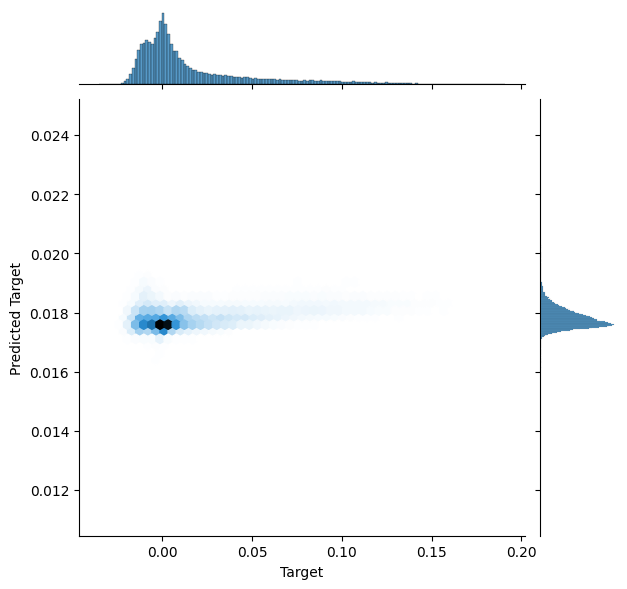

In [102]:
import seaborn as sns
sns.jointplot(x = test_data[output_cols[0]], y = mu, kind = 'hex')
plt.xlabel('Target')
plt.ylabel('Predicted Target')
plt.show()

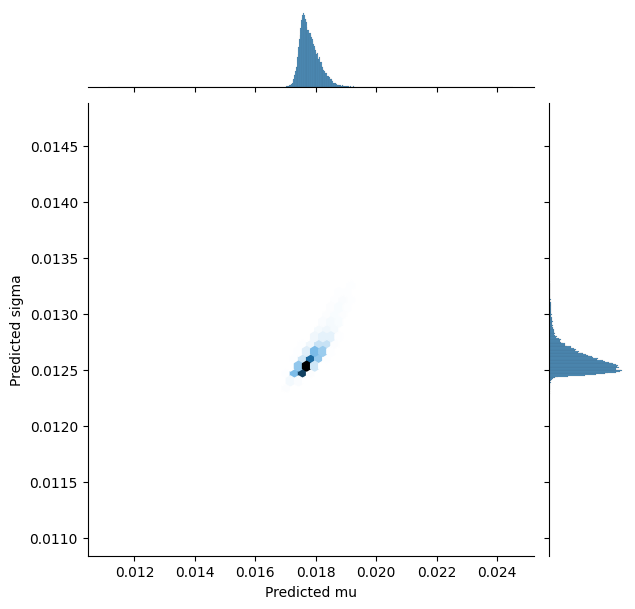

In [103]:
sns.jointplot(x = mu, y = np.sqrt(var), kind = 'hex')
plt.xlabel('Predicted mu')
plt.ylabel('Predicted sigma')
plt.show()

In [ ]:
del model
tf.keras.backend.clear_session()
gc.collect()

### B. Compute uncertanties 

### 1a. First with the standard model via MC dropout sampling

In [30]:
def get_monte_carlo_predictions(x_test, 
                                forward_passes,
                                model,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, 1))
    for i in range(forward_passes):
        predictions = np.empty((0, 1))
        output = y_scaler.inverse_transform(model.call(x_test, training=True))
        predictions = np.vstack((predictions, output))
        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)
    
    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0) # shape (n_samples, n_classes)
    
    return mean, variance

In [31]:
forward_passes = 1000
n_samples = x_test.shape[0]

mu, sigma = get_monte_carlo_predictions(x_test,
                                        forward_passes,
                                        mlp,
                                        n_samples)

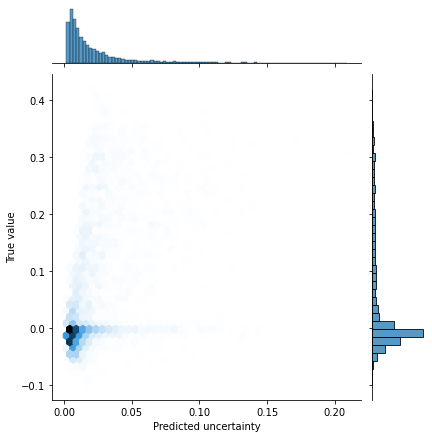

In [32]:
sns.jointplot(x = np.sqrt(sigma[:, 0]), y = test_data[output_cols[0]], kind = 'hex')
plt.xlabel('Predicted uncertainty')
plt.ylabel('True value')
plt.show()

### 1b. Create ensemble of ensembles with standard MLP to compute evidential components

In [33]:
ensemble_mu = np.zeros((n_models, test_data.shape[0], 1))
ensemble_sigma = np.zeros((n_models, test_data.shape[0], 1))

for model_seed in range(n_models):

    _model = MLP()
    _ensemble_pred = np.zeros((n_splits, test_data.shape[0], 1))
    
    for data_seed in tqdm.tqdm(range(n_splits)):
        data = pd.read_csv(fn)
        data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

        # Need the same test_data for all trained models (data and model ensembles)
        flat_seed = 1000
        gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
        splits = list(gsp.split(data, groups = data["day"]))
        train_index, test_index = splits[0]
        train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

        # Make N train-valid splits using day as grouping variable
        gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(train_data, groups = train_data["day"]))
        train_index, valid_index = splits[data_seed]
        train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

        x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
        x_train = x_scaler.fit_transform(train_data[input_cols])
        x_valid = x_scaler.transform(valid_data[input_cols])
        x_test = x_scaler.transform(test_data[input_cols])

        y_train = y_scaler.fit_transform(train_data[output_cols])
        y_valid = y_scaler.transform(valid_data[output_cols])
        y_test = y_scaler.transform(test_data[output_cols])

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=1e-5
        )
        
        model = copy.deepcopy(_model)

        # compile model
        model.compile(
            optimizer = optimizer, 
            loss = "mae",
            metrics = ['mae'],
            run_eagerly=True
        )

        callback1 = tf.keras.callbacks.EarlyStopping(
            monitor = 'val_mae', 
            mode = 'min',
            patience = 15,
            restore_best_weights = True
        )
        callback2 = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_mae', 
            factor = 0.1, 
            patience = 3, 
            verbose = 0,
            mode = 'min',
            min_lr = 1e-7
        )
        # fit model to training data
        history = model.fit(
            x = x_train, 
            y = y_train,
            validation_data = (x_valid, y_valid),
            batch_size = 256,
            epochs = 500,
            callbacks = [callback1, callback2],
            verbose = 0
        )

        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(x_test))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()

    ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

100%|██████████| 10/10 [09:58<00:00, 59.83s/it]


In [34]:
mlp_aleatoric = np.mean(ensemble_sigma, 0)
mlp_epistemic = np.var(ensemble_mu, 0)

In [35]:
print(mlp_epistemic.mean() ** (1/2), mlp_aleatoric.mean() ** (1/2))

0.000542891349707717 0.0024902650909771557


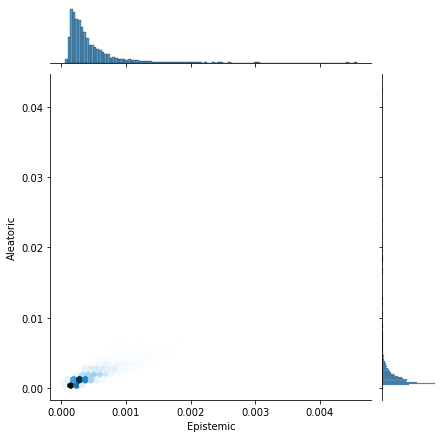

In [36]:
sns.jointplot(x = np.sqrt(mlp_epistemic[:, 0]), y = np.sqrt(mlp_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

### 2. Next with the Gaussian model, create a deep ensemble

In [233]:
data_seed = 0
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]

In [235]:
n_splits = 10
output_cols = [
    'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1'
]

ensemble_mu = np.zeros((n_splits, test_data.shape[0], 1))
ensemble_var = np.zeros((n_splits, test_data.shape[0], 1))

for data_seed in tqdm.tqdm(range(n_splits)):
    data = pd.read_csv(fn)
    data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

    # Need the same test_data for all trained models (data and model ensembles)
    flat_seed = 1000
    gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
    splits = list(gsp.split(data, groups = data["day"]))
    train_index, test_index = splits[0]
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

    # Make N train-valid splits using day as grouping variable
    gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
    splits = list(gsp.split(train_data, groups = train_data["day"]))
    train_index, valid_index = splits[data_seed]
    train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

    x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
    x_train = x_scaler.fit_transform(train_data[input_cols])
    x_valid = x_scaler.transform(valid_data[input_cols])
    x_test = x_scaler.transform(test_data[input_cols])

    y_train = y_scaler.fit_transform(train_data[output_cols])
    y_valid = y_scaler.transform(valid_data[output_cols])
    y_test = y_scaler.transform(test_data[output_cols])
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units = 256, activation='relu', kernel_regularizer=l2(1e-7)),
            tf.keras.layers.Dense(units = 256, activation='relu', kernel_regularizer=l2(1e-7)),
            tf.keras.layers.Dense(units = 256, activation='relu', kernel_regularizer=l2(1e-7)),
            tf.keras.layers.Dense(units = 256, activation='relu', kernel_regularizer=l2(1e-7)),
            #tf.keras.layers.Dense(units = 4500, activation = 'relu'),
            #tf.keras.layers.Dropout(),
            tf.keras.layers.Dense(units = 2, activation = 'sigmoid'),
        ]
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )
    
    # compile model
    model.compile(
        optimizer = optimizer, 
        loss = NLL,
        metrics = ['mae'],
        #run_eagerly=True
    )
    
    callback1 = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_mae', 
        mode = 'min',
        patience = 5,
        restore_best_weights = True
    )
    callback2 = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_mae', 
        factor = 0.1, 
        patience = 3, 
        verbose = 0,
        mode = 'min',
        min_lr = 1e-7
    )
    # fit model to training data
    history = model.fit(
        x = x_train, 
        y = y_train,
        validation_data = (x_valid, y_valid),
        batch_size = 256,
        epochs = 500,
        callbacks = [callback1, callback2],
        verbose = 0
    )
    
    y_pred = model.predict(x_test)
    mu, var = (y_pred[:, i] for i in range(y_pred.shape[1]))
    mu = y_scaler.inverse_transform(np.expand_dims(mu, axis = 1)).squeeze(-1)
    var = np.expand_dims(var, axis = 1).squeeze(-1)
    var *= train_data[output_cols].var().to_numpy()[0]
    mae = np.mean(np.abs(mu-test_data[output_cols[0]]))
    
    ensemble_mu[data_seed] = np.expand_dims(mu, 1)
    ensemble_var[data_seed] = np.expand_dims(var, 1)
    
    del model
    tf.keras.backend.clear_session()
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

2260/2260 [==============================] - 2s 790us/step


 10%|█         | 1/10 [00:50<07:31, 50.19s/it]

2260/2260 [==============================] - 2s 783us/step


 20%|██        | 2/10 [01:40<06:40, 50.08s/it]

2260/2260 [==============================] - 2s 784us/step


 30%|███       | 3/10 [02:30<05:51, 50.19s/it]

2260/2260 [==============================] - 2s 786us/step


 40%|████      | 4/10 [03:20<05:00, 50.12s/it]

2260/2260 [==============================] - 2s 788us/step


 50%|█████     | 5/10 [04:10<04:11, 50.24s/it]

2260/2260 [==============================] - 2s 762us/step


 60%|██████    | 6/10 [05:00<03:20, 50.09s/it]

2260/2260 [==============================] - 2s 814us/step


 70%|███████   | 7/10 [05:50<02:30, 50.09s/it]

2260/2260 [==============================] - 2s 790us/step


 80%|████████  | 8/10 [06:40<01:40, 50.06s/it]

2260/2260 [==============================] - 2s 769us/step


 90%|█████████ | 9/10 [07:31<00:50, 50.14s/it]

2260/2260 [==============================] - 2s 793us/step


100%|██████████| 10/10 [08:21<00:00, 50.11s/it]


In [236]:
epistemic = np.var(ensemble_mu, axis=0)
aleatoric = np.mean(ensemble_var, axis=0)

In [237]:
print(epistemic.mean() ** (1/2), aleatoric.mean() ** (1/2))

0.0036773566974972753 0.013623816356423462


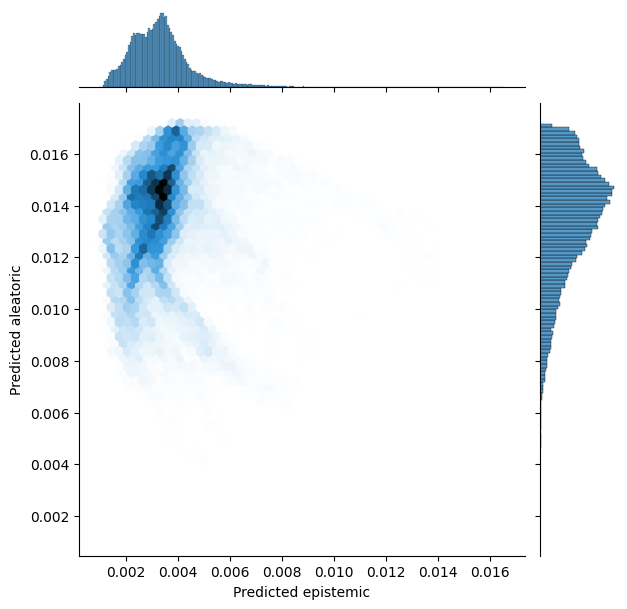

In [238]:
sns.jointplot(x = np.sqrt(epistemic[:, 0]), y = np.sqrt(aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Predicted epistemic')
plt.ylabel('Predicted aleatoric')
plt.show()

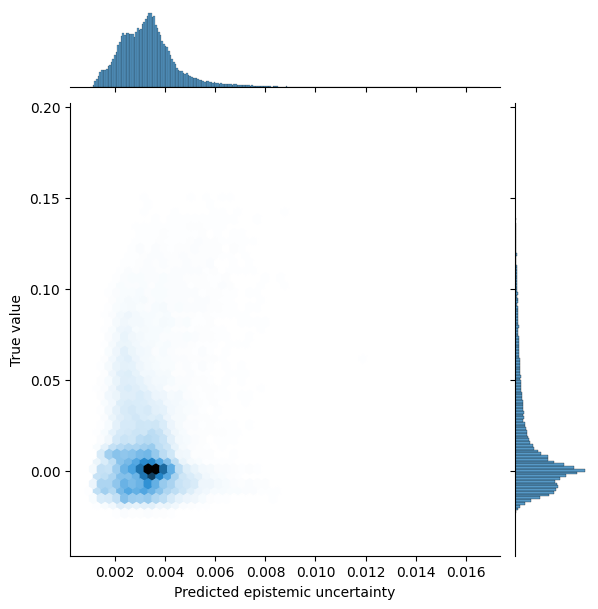

In [239]:
sns.jointplot(x = np.sqrt(epistemic[:, 0]), y = test_data[output_cols[0]], kind = 'hex')
plt.xlabel('Predicted epistemic uncertainty')
plt.ylabel('True value')
plt.show()

/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

defaultdict(<class 'list'>, {'e': [0.0015326546506899351], 'a': [0.0016566762640970144]})
defaultdict(<class 'list'>, {'e': [nan], 'a': [0.016058964191890644]})


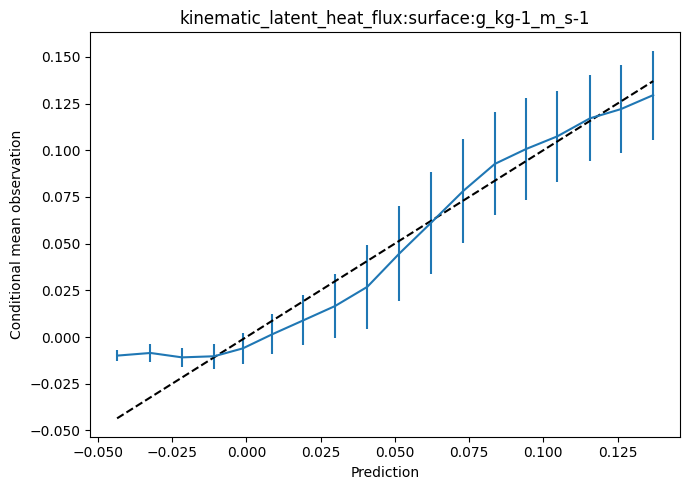

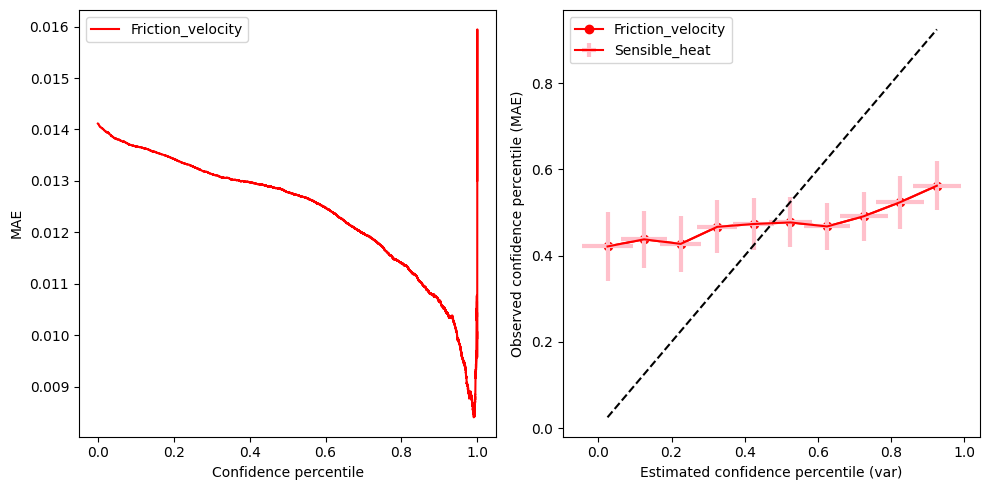

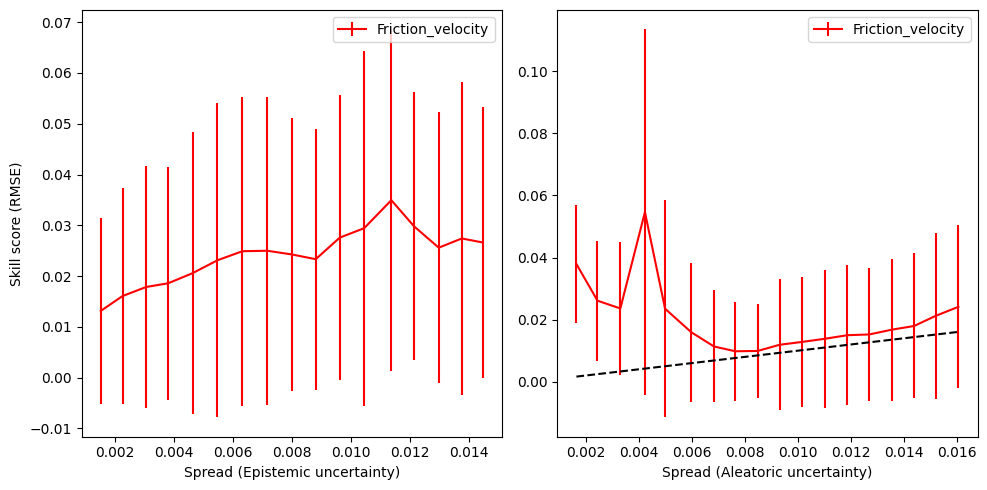

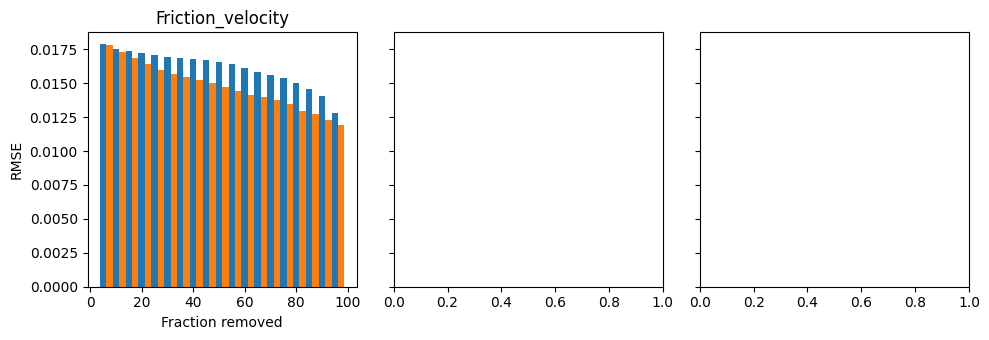

In [242]:
compute_results(test_data, output_cols, np.mean(ensemble_mu, axis=0), np.sqrt(aleatoric), np.sqrt(epistemic))

### 3. Finally, with the normal inverse gamma approach for estimating evidential uncertainty

In [170]:
class DenseNormalGamma(tf.keras.layers.Layer):
    """Implements dense layer for Deep Evidential Regression
    
    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """
    
    def __init__(self, units):
        super(DenseNormalGamma, self).__init__()
        self.units = int(units)
        self.dense = tf.keras.layers.Dense(4 * self.units, activation=None)

    def evidence(self, x):
        return tf.nn.softplus(x)

    def call(self, x):
        output = self.dense(x)
        mu, logv, logalpha, logbeta = tf.split(output, 4, axis=-1)
        v = self.evidence(logv)
        alpha = self.evidence(logalpha) + 1
        beta = self.evidence(logbeta)
        return tf.concat([mu, v, alpha, beta], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4 * self.units)

    def get_config(self):
        base_config = super(DenseNormalGamma, self).get_config()
        base_config['units'] = self.units
        return base_config

In [171]:
def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    v += 1e-12
    twoBlambda = 2*beta*(1+v) + 1e-12
    nll = 0.5*tf.math.log(np.pi/v)  \
        - alpha*tf.math.log(twoBlambda)  \
        + (alpha+0.5) * tf.math.log(v*(y-gamma)**2 + twoBlambda)  \
        + tf.math.lgamma(alpha)  \
        - tf.math.lgamma(alpha+0.5)

    return tf.reduce_mean(nll) if reduce else nll

def NIG_Reg(y, gamma, v, alpha, beta, reduce=True):
    error = tf.abs(y-gamma)
    evi = 2*v+(alpha)
    reg = error*evi

    return tf.reduce_mean(reg) if reduce else reg

def EvidentialRegression(y_true, evidential_output, coeff=1.0):
    """Implements loss for Deep Evidential Regression
    
    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """
    
    gamma, v, alpha, beta = tf.split(evidential_output, 4, axis=-1)
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta)
    return loss_nll + coeff * loss_reg

In [172]:
data_seed = 0
flat_seed = 1000
n_splits = 1

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

In [173]:
evm = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units = 4500, activation = 'relu'),
        #tf.keras.layers.Dropout(),
        DenseNormalGamma(3)
    ]
)

In [174]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [175]:
loss = partial(EvidentialRegression, coeff=0.15)

# compile model
evm.compile(
    optimizer = optimizer, 
    loss = loss
    #metrics = ['mae']
)

In [176]:
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min'
)

In [177]:
# fit model to training data
history = evm.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 1
)

Epoch 1/500
2245/2245 [==============================] - 8s 3ms/step - loss: 0.3976 - val_loss: -0.1571 - lr: 1.0000e-05
Epoch 2/500
2245/2245 [==============================] - 7s 3ms/step - loss: -0.4357 - val_loss: -0.8310 - lr: 1.0000e-05
Epoch 3/500
2245/2245 [==============================] - 8s 3ms/step - loss: -0.9381 - val_loss: -1.2724 - lr: 1.0000e-05
Epoch 4/500
2245/2245 [==============================] - 7s 3ms/step - loss: -1.5197 - val_loss: -1.6736 - lr: 1.0000e-05
Epoch 5/500
2245/2245 [==============================] - 7s 3ms/step - loss: -1.9325 - val_loss: -2.0340 - lr: 1.0000e-05
Epoch 6/500
2245/2245 [==============================] - 7s 3ms/step - loss: -2.1307 - val_loss: -2.1095 - lr: 1.0000e-05
Epoch 7/500
2245/2245 [==============================] - 7s 3ms/step - loss: -2.1934 - val_loss: -2.1673 - lr: 1.0000e-05
Epoch 8/500
2245/2245 [==============================] - 7s 3ms/step - loss: -2.2245 - val_loss: -2.1928 - lr: 1.0000e-05
Epoch 9/500
2245/2245 [==

In [178]:
y_pred = evm.predict(x_test)

2260/2260 [==============================] - 2s 828us/step


In [179]:
# compute variance and std from learned parameters
mu, v, alpha, beta = np.split(y_pred, 4, axis=-1)
var_a = beta / (alpha - 1 + 1e-8)
var_e = beta / (v * (alpha - 1) + 1e-8)

In [180]:
mu = y_scaler.inverse_transform(mu)
for k,col in enumerate(output_cols):
    var_a[:, k] *= train_data[col].var()
    var_e[:, k] *= train_data[col].var()

In [181]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
var = np.var(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, var, np.sqrt(var_e).mean(), np.sqrt(var_a).mean())

0.028958423550092878 0.0007156299921313998 0.0021481824 0.00079219113


/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

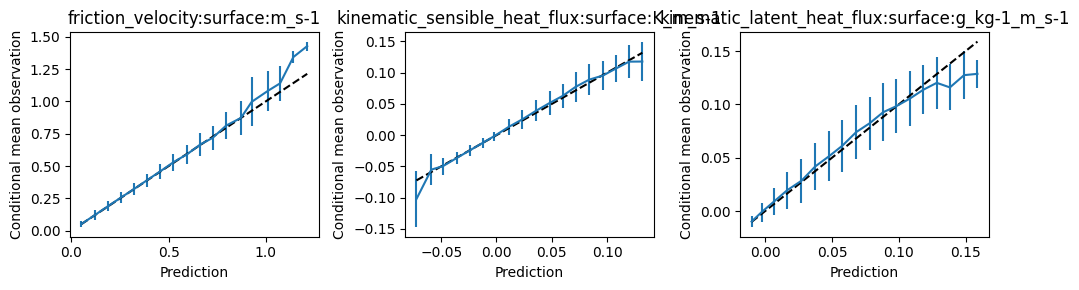

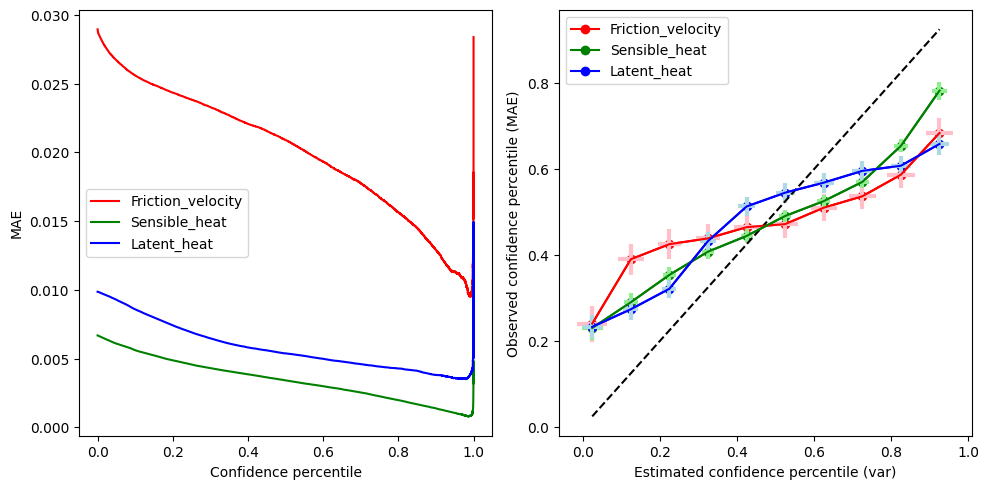

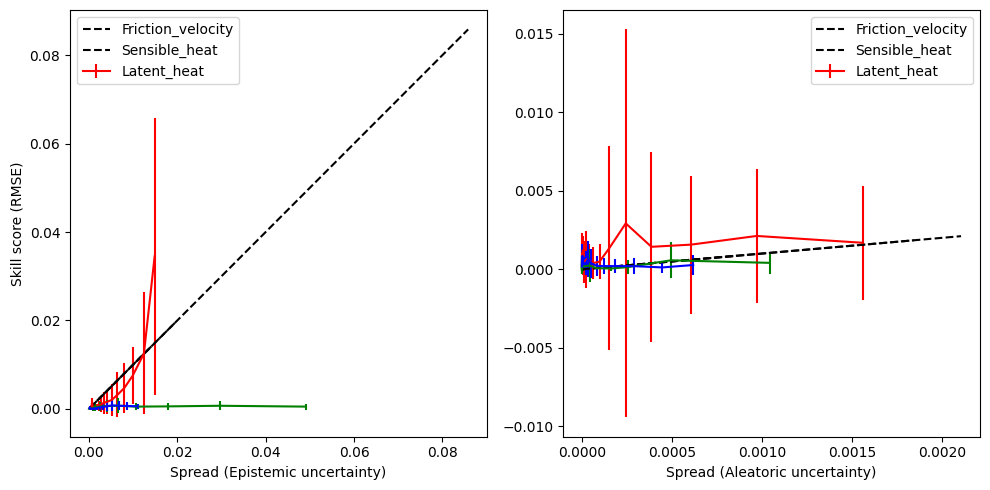

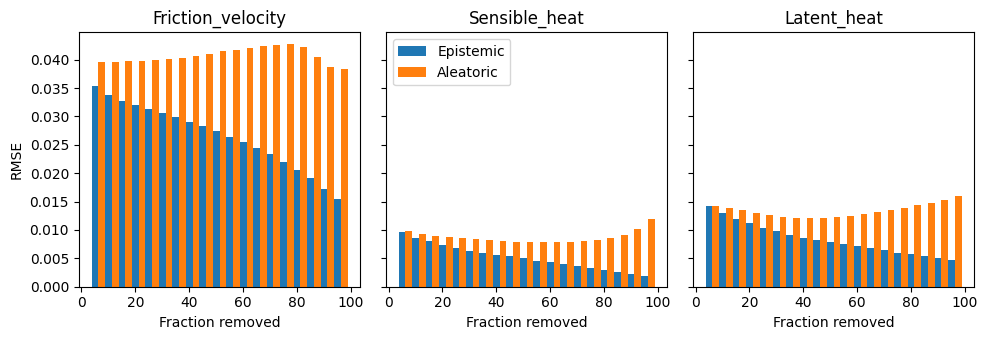

In [185]:
compute_results(test_data, output_cols, mu, np.sqrt(var_a), np.sqrt(var_e))

In [ ]:
# sns.jointplot(x = np.sqrt(var_e), y = np.sqrt(var_a), kind = 'hex')
# plt.xlabel('Predicted epistemic')
# plt.ylabel('Predicted aleatoric')
# plt.show()

In [18]:
# sns.jointplot(x = np.sqrt(var_e), y = test_data[output_cols[0]].to_numpy(), kind = 'hex')
# plt.xlabel('Predicted epistemic')
# plt.ylabel('True value')
# plt.show()

In [46]:
# pred_cols = [f"{x}_pred" for x in output_cols]
# mae_cols = [f"{x}_mae" for x in output_cols]
# rmse_cols = [f"{x}_rmse" for x in output_cols]
# a_cols = [f"{x}_a" for x in output_cols]
# e_cols = [f"{x}_e" for x in output_cols]
# test_data[pred_cols] = mu
# test_data[a_cols] = np.sqrt(var_a)
# test_data[e_cols] = np.sqrt(var_e)

# test_data[mae_cols] = np.abs(mu - test_data[output_cols])
# test_data[rmse_cols] = np.square(mu - test_data[output_cols])

In [219]:
def compute_results(df, output_cols, mu, aleatoric, epistemic):
    mu_cols = [f"{x}_pred" for x in output_cols]
    err_cols = [f"{x}_err" for x in output_cols]
    e_cols = [f"{x}_e" for x in output_cols]
    a_cols = [f"{x}_a" for x in output_cols]
    # Add the predictions to the dataframe and compute absolute error
    df[mu_cols] = mu
    df[a_cols] = aleatoric
    df[e_cols] = epistemic
    df[err_cols] = np.abs(mu - df[output_cols])
    legend_cols = ['Friction_velocity', 'Sensible_heat', 'Latent_heat']
    
    # Compute attributes figure
    regression_attributes(df, output_cols)
    # Compute calibration curve and MAE versus sorted uncertainty
    calibration(df, legend_cols, e_cols, err_cols)
    # spread-skill
    spread_skill(df, output_cols)
    # discard fraction
    discard_fraction(df, output_cols)
    
    
def compute_coverage(df, col = "var", quan = "error"):
    df = df.copy()
    df = df.sort_values(col, ascending = True)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = 1 - df["dummy"].cumsum() / len(df)
    return df

def calibration_curve(df, col = "var", quan = "error", bins = 10):
    obs = df.sort_values(quan, ascending = True).copy()
    obs[f"{quan}_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
    h, b1, b2 = np.histogram2d(obs[f"{col}_cov"], obs[f"{quan}_cov"], bins = bins)
    cov_var = np.arange(0.025, 1.025, 1. / float(bins))
    cov_mae = [np.average(cov_var, weights = hi) for hi in h]
    cov_mae_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]
    cov_var_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h.T]
    return cov_var, cov_mae, cov_mae_std, cov_var_std

def calibration(f, output_cols, e_cols, mae_cols, bins = 10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    colors = ["r", "g", "b"]
    lcolors = ["pink", "lightgreen", "lightblue"]
    
    for e_col, mae_col, col, lcol in zip(e_cols, mae_cols, colors, lcolors):
        #  Coverage (sorted uncertainty) versus cumulative metric
        df = compute_coverage(test_data, col = e_col, quan = mae_col)
        ax1.plot(df[f"{e_col}_cov"], df[f"cu_{mae_col}"], zorder = 2, color = col)
        
        cov_var, cov_mae, cov_mae_std, cov_var_std = calibration_curve(
            df, col = e_col, quan = mae_col, bins = bins
        )
        
        ax2.plot(cov_var, cov_mae,  f"{col}-o")
        ax2.errorbar(
            cov_var, cov_mae, 
            xerr = cov_var_std, 
            yerr = cov_mae_std,
            capsize=0, 
            c = col, 
            elinewidth=3, 
            ecolor=lcol
        )
        
        ax1.set_xlabel("Confidence percentile")
        ax1.set_ylabel("MAE")
        
        ax2.set_xlabel("Estimated confidence percentile (var)")
        ax2.set_ylabel("Observed confidence percentile (MAE)")
        
    ax1.legend(output_cols)
    ax2.legend(output_cols)
    ax2.plot(cov_var, cov_var, 'k--')
    plt.tight_layout()
    

def spread_skill(df, output_cols, nbins = 20):
    colors = ["r", "g", "b"]
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    lower_bounds = defaultdict(list)
    upper_bounds = defaultdict(list)
    for k, col in enumerate(output_cols):
        for j, u in enumerate(["e", "a"]):
            upper = 1.01 * max(df[f'{col}_{u}'])
            lower = 0.99 * min(df[f'{col}_{u}'])
            lower = lower if np.isfinite(lower) else 0.99*max(df[f'{col}_{u}'][~df[f'{col}_{u}'].isna()])
            upper = upper if np.isfinite(upper) else 1.01*min(df[f'{col}_{u}'][~df[f'{col}_{u}'].isna()])
            
            if (np.log10(upper) - np.log10(lower)) > 2:
                bins = np.logspace(np.log10(lower), np.log10(upper), nbins)
            else:
                bins = np.linspace(lower, upper, nbins)
            bin_range = np.digitize(test_data[f'{col}_{u}'].values, bins = bins, right = True)
            bin_means = [test_data[f'{col}_{u}'][bin_range == i].mean() for i in range(1, len(bins))]
            histogram = defaultdict(list)
            for bin_no in range(1, max(list(set(bin_range)))):
                idx = np.where(bin_range == bin_no)
                residuals = test_data[f'{col}_err'].values[idx] ** 2
                mean = np.mean(residuals) ** (1/2)
                std = np.std(residuals) ** (1/2)
                histogram["bin"].append(bin_means[bin_no-1])
                histogram["mean"].append(mean)
                histogram["std"].append(std)
            axs[j].errorbar(
                histogram["bin"], 
                histogram["mean"],
                yerr = histogram["std"],
                c = colors[k]
            )
            axs[j].legend(legend_cols)
            lower_bounds[u].append(bin_means[0])
            upper_bounds[u].append(bin_means[-2])

    bins = np.linspace(min(lower_bounds["e"]), max(upper_bounds["e"]), nbins)
    axs[0].plot(bins, bins, color = "k", ls = "--")
    bins = np.linspace(min(lower_bounds["a"]), max(upper_bounds["a"]), nbins)
    axs[1].plot(bins, bins, color = "k", ls = "--")
    axs[0].set_xlabel("Spread (Epistemic uncertainty)")
    axs[1].set_xlabel("Spread (Aleatoric uncertainty)")
    axs[0].set_ylabel("Skill score (RMSE)")
    
    # axs[0].set_xscale("log")
    # axs[0].set_yscale("log")
    # axs[1].set_xscale("log")
    # axs[1].set_yscale("log")
    
    plt.tight_layout()
    
    
def discard_fraction(df, output_cols):
    for col in output_cols:
        df = compute_coverage(df, col = f"{col}_e", quan = f"{col}_err")
        df = compute_coverage(df, col = f"{col}_a", quan = f"{col}_err")
    fig, axs = plt.subplots(1, 3, figsize = (10, 3.5), sharey = "row")
    for k, col in enumerate(output_cols):
        results = defaultdict(list)
        for percent in range(5, 105, 5):
            c = df[f'{col}_e_cov'] >= percent / 100.0
            results["rmse_e"].append(np.square(df[c][f"{col}_err"]).mean() ** (1/2))
            c = df[f'{col}_a_cov'] >= percent / 100.0
            results["rmse_a"].append(np.square(df[c][f"{col}_err"]).mean() ** (1/2))
            results["frac"].append(percent)

        axs[k].bar(results["frac"], results["rmse_e"], 2.5)
        axs[k].bar([x + 2.5 for x in results["frac"]], results["rmse_a"], 2.5)
        axs[k].set_xlabel("Fraction removed")
        axs[k].set_title(legend_cols[k])

        if k == 1: 
            axs[k].legend(["Epistemic", "Aleatoric"])
    axs[0].set_ylabel("RMSE")
    plt.tight_layout()
    
    
def regression_attributes(df, output_cols, bins = 11):
    width = 7 if len(output_cols) == 1 else 10
    height = 5    
    fig, axs = plt.subplots(1, len(output_cols), figsize = (width, height))
    
    if len(output_cols) == 1:
        axs = [axs]

    for k, col in enumerate(output_cols):
        upper = 1.01 * max(df[f'{col}_pred']) 
        lower = 0.99 * min(df[f'{col}_pred']) 
        bins = np.linspace(lower, upper, nbins)
        bin_range = np.digitize(df[f'{col}_pred'].values, bins = bins)
        bin_means = [df[f'{col}_pred'][bin_range == i].mean() for i in range(1, len(bins))]
        histogram = defaultdict(list)
        for bin_no in range(1, max(list(set(bin_range)))):
            idx = np.where(bin_range == bin_no)
            residuals = df[f'{col}'].values[idx]
            mean = np.mean(residuals) 
            std = np.std(residuals)
            histogram["bin"].append(bin_means[bin_no-1])
            histogram["mean"].append(mean)
            histogram["std"].append(std)
        axs[k].errorbar(histogram["bin"], histogram["mean"], yerr = histogram["std"])
        axs[k].plot(histogram["bin"], histogram["bin"], 'k--')

        axs[k].set_title(f"{col}")
        axs[k].set_ylabel("Conditional mean observation")
        axs[k].set_xlabel("Prediction")

    plt.tight_layout()

/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/work/schreck/miniconda3/envs/risk/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

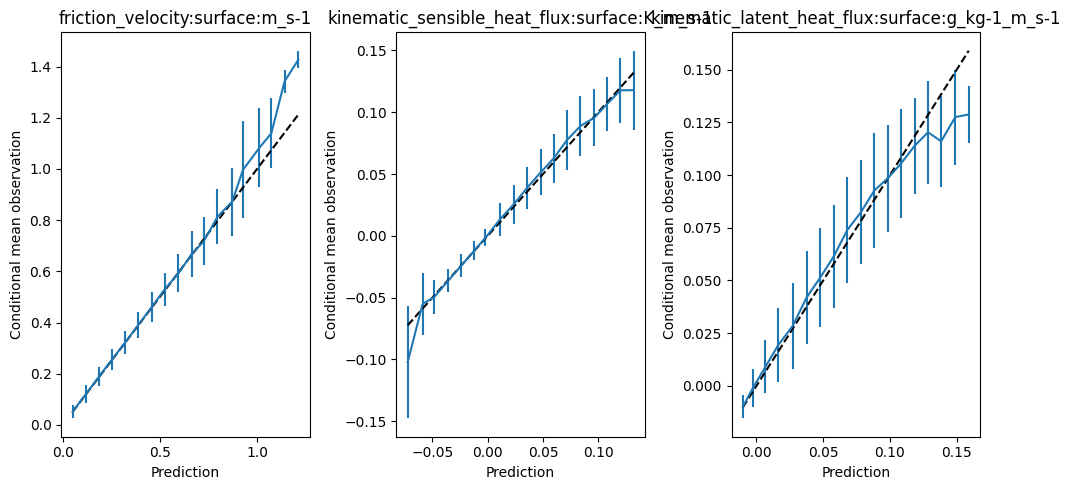

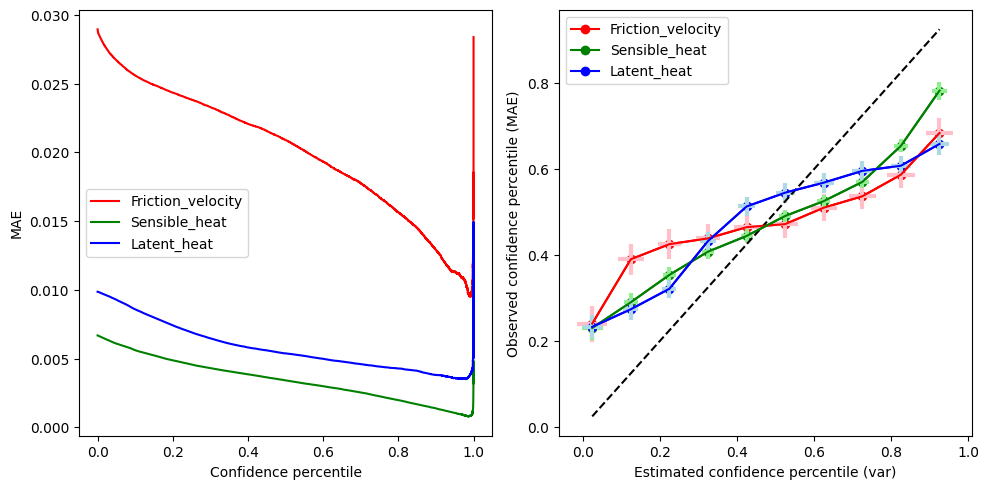

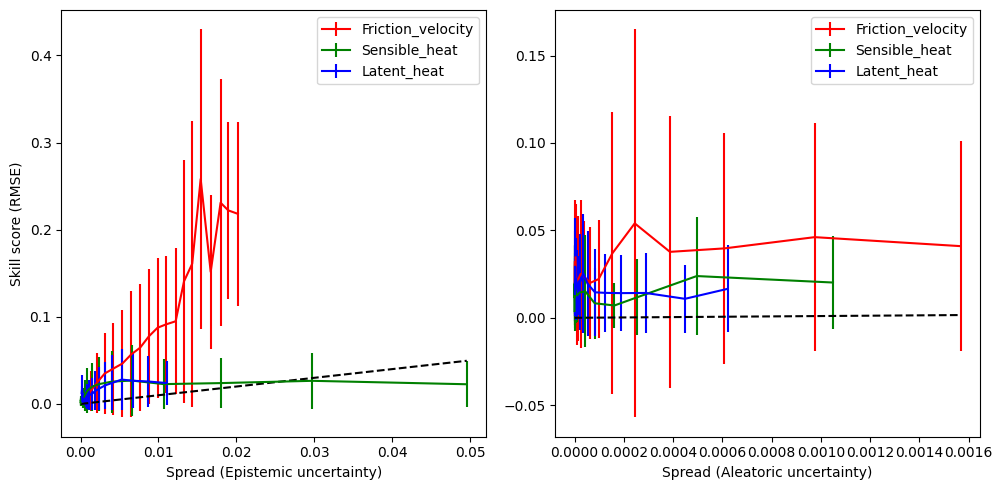

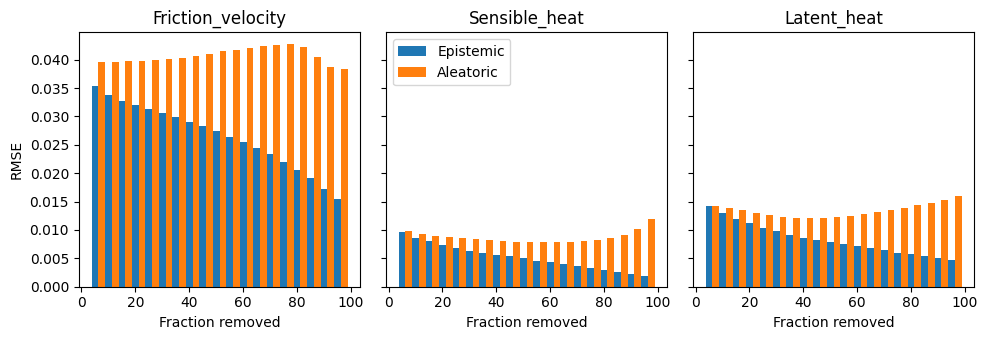

In [220]:
compute_results(test_data, output_cols, mu, np.sqrt(var_a), np.sqrt(var_e))

In [42]:
#legend_cols = ['Friction_velocity', 'Sensible_heat', 'Latent_heat']
#calibration(test_data, legend_cols, e_cols, mae_cols)

### Spread-skill scores

In [37]:
# nbins = 20
# colors = ["r", "g", "b"]
# fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# for k, col in enumerate(output_cols):
    
#     for j, u in enumerate(["e", "a"]):
    
#         upper = np.percentile(test_data[f'{col}_{u}'], 95)
#         lower = np.percentile(test_data[f'{col}_{u}'], 5)

#         lower = lower if np.isfinite(lower) else 1e-2
#         upper = upper if np.isfinite(upper) else 1e-2

#         bins = np.logspace(np.log10(lower), np.log10(upper), nbins)
#         bin_range = np.digitize(test_data[f'{col}_{u}'].values, bins = bins)
#         #print(np.bincount(bin_range))
#         bin_means = [test_data[f'{col}_{u}'][bin_range == i].mean() for i in range(1, len(bins))]
#         histogram = defaultdict(list)
#         for bin_no in range(1, max(list(set(bin_range)))):
#             idx = np.where(bin_range == bin_no)
#             mean = np.mean(test_data[f'{col}_rmse'].values[idx]) ** (1/2)
#             std = np.std(test_data[f'{col}_rmse'].values[idx])

#             histogram["bin"].append(bin_means[bin_no-1])
#             histogram["mean"].append(mean)
#             histogram["std"].append(std)
#             #histogram["count"].append(idx.sum())

#         axs[j].errorbar(
#             histogram["bin"], 
#             histogram["mean"],
#             yerr = histogram["std"],
#             c = colors[k]
#         )

# for ax in axs:
#     ax.legend(legend_cols)
#     ax.plot(
#         np.logspace(-4, -2, 20), 
#         np.logspace(-4, -2, 20), 
#         color = "k", ls = "--")
#     #ax.set_xscale("log")
#     #ax.set_yscale("log")

# axs[0].set_xlabel("Spread (Epistemic uncertainty)")
# axs[1].set_xlabel("Spread (Aleatoric uncertainty)")
# axs[0].set_ylabel("Skill score (RMSE)")

### Discard fraction

In [56]:
#discard_fraction(test_data, output_cols)

In [57]:
# df = test_data.copy()
# for e_col, mae_col in zip(e_cols, mae_cols):
#     df = compute_coverage(df, col = e_col, quan = mae_col)
# for a_col, mae_col in zip(a_cols, mae_cols):
#     df = compute_coverage(df, col = a_col, quan = mae_col)

In [58]:
# fig, axs = plt.subplots(1, 3, figsize = (10, 3.5), sharey = "row")

# for k, col in enumerate(output_cols):
#     results = defaultdict(list)
#     for percent in range(5, 105, 5):
#         c = df[f'{col}_e_cov'] >= percent / 100.0
#         results["rmse_e"].append(df[c][f"{col}_rmse"].mean() ** (1/2))
#         c = df[f'{col}_a_cov'] >= percent / 100.0
#         results["rmse_a"].append(df[c][f"{col}_rmse"].mean() ** (1/2))
#         results["frac"].append(percent)

#     axs[k].bar(results["frac"], results["rmse_e"], 2.5)
#     axs[k].bar([x + 2.5 for x in results["frac"]], results["rmse_a"], 2.5)
#     axs[k].set_xlabel("Fraction removed")
#     axs[k].set_title(legend_cols[k])
    
#     if k == 1: 
#         axs[k].legend(["Epistemic", "Aleatoric"])
#     #axs[k].set_yscale("log")
# axs[0].set_ylabel("RMSE")

In [62]:
columns = output_cols + [f'{x}_pred' for x in output_cols] + [f'{x}_e' for x in output_cols] + [f'{x}_a' for x in output_cols] + [f'{x}_err' for x in output_cols]
test_data[columns].to_csv("SL_evidential.csv")